In [124]:
import numpy as np
import torch
from torch import cuda

import DeepEmotionModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"
net = DeepEmotionModel.DeepEmotionModel()
# 加载模型
net.load_state_dict(torch.load("cosann-best-0.pt", map_location=device))
net.to(device)

DeepEmotionModel(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(in

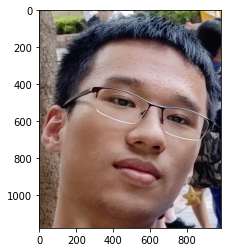

In [125]:
import cv2
import matplotlib.pyplot as plt

frame = cv2.imread('face3.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# plt.imshow(frame)

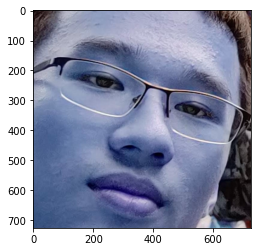

In [126]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
# 转换成灰度
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# 这一步是找出人脸
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
faceCropped = None
for x, y, w, h in faces:
    # 人脸的灰度版本
    faceInGray = gray[y:y + h, x:x + w]
    # plt.imshow(roiGray)
    # 同上,但是是RGB
    faceInColor = frame[y:y + h, x:x + w]
    # 如果人脸不是特别正,就别做下面的裁剪了,不然效果更差
    # plt.imshow(faceInColor)
    faceCropped = faceInColor
    # 此处,让我们给人脸画上一个矩形框
    cv2.rectangle(frame, (x, y), (x + w, y + w), (255, 0, 0), 4)
    # 精确人脸提取
    facess = faceCascade.detectMultiScale(faceInGray)
    # print(facess)
    # print(len(facess))
    if len(facess) == 0:
        print("没有检测到人脸")
    else:
        for (ex, ey, ew, eh) in facess:
            faceCropped = faceInColor[ey:ey + eh, ex:ex + ew]
            plt.imshow(faceCropped)

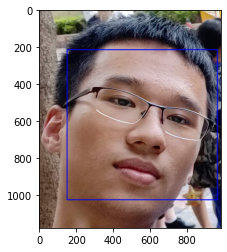

In [127]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

拿到人脸之后要处理一下

- 灰度化
- 压缩到 48x48 也就是数据集的大小
- 用 numpy 扩展到 48x48x1x1

(1, 1, 48, 48)

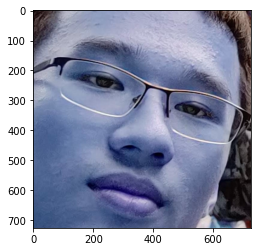

In [128]:
faceCroppedGray = cv2.cvtColor(faceCropped, cv2.COLOR_BGR2GRAY)
plt.imshow(faceCropped)
faceReshaped = cv2.resize(faceCroppedGray, (48, 48))
# plt.imshow(cv2.cvtColor(faceReshaped, cv2.COLOR_GRAY2RGB))
faceExpand = np.expand_dims(faceReshaped, axis=0)
faceExpand = np.expand_dims(faceExpand, axis=0)
faceExpand.shape

送去神经网络之前要做处理

- 标准化
- 转换为张量
- 如果可以就放到 GPU 上

In [129]:
faceExpand = faceExpand / 255.0
faceTensor = torch.from_numpy(faceExpand)
faceTensor = faceTensor.type(torch.FloatTensor)
if torch.cuda.is_available():
    faceTensor = faceTensor.cuda()
    faceTensor.to(device)

现在来计算输出

In [130]:
import torch.nn.functional as F

# 此处是 FER2013 的定义
#  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
emotions = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
outputs = net(faceTensor)
pred = F.softmax(outputs, dim=1)
# 看预测结果
print(pred)
# 找出最大的那个预测结果的索引
predIndex = torch.argmax(pred, dim=1)
print(f"最有可能的标签是: {predIndex}")
print(f"最有可能的情绪是: {emotions[predIndex]}")

tensor([[0.0426, 0.0052, 0.1790, 0.0894, 0.2476, 0.2540, 0.1822]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
最有可能的标签是: tensor([5], device='cuda:0')
最有可能的情绪是: Surprise


最后我们尝试在原图上标注出预测的结果
不过这是选做的,咕咕咕